## Will Millennials Ever Get Married?

This notebook contains analysis related to a paper on marriage patterns in the U.S., based on data from the National Survey of Family Growth (NSFG).

It is based on Chapter 13 of Think Stats, 2nd Edition, by Allen Downey, available from [thinkstats2.com](http://thinkstats2.com)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as pyplot
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

import thinkstats2
import thinkplot

import survival
import marriage

Load the data:

In [2]:
resp8 = marriage.ReadFemResp2013()
marriage.Validate2013(resp8)

resp7 = marriage.ReadFemResp2010()
marriage.Validate2010(resp7)

resp6 = marriage.ReadFemResp2002()
marriage.Validate2002(resp6)

resp5 = marriage.ReadFemResp1995()
marriage.Validate1995(resp5)

resp4 = marriage.ReadFemResp1988()
marriage.Validate1988(resp4)

resp3 = marriage.ReadFemResp1982()
marriage.Validate1982(resp3)

Make a list of DataFrames, one for each cycle:

In [3]:
resps = [resp8, resp7, resp6, resp5, resp4, resp3]

Make a table showing the number of respondents in each cycle:

In [4]:
def SummarizeCycle(df):
    ages = df.age.min(), df.age.max()
    ages= np.array(ages)
    
    intvws = df.cmintvw.min(), df.cmintvw.max()
    intvws = np.array(intvws) / 12 + 1900
    
    births = df.cmbirth.min(), df.cmbirth.max()
    births = np.array(births) / 12 + 1900

    print('# & ', intvws.astype(int), '&', len(df), '&', births.astype(int), r'\\')
    
for resp in reversed(resps):
    SummarizeCycle(resp)

# &  [1982 1983] & 7969 & [1937 1968] \\
# &  [1988 1988] & 8450 & [1943 1973] \\
# &  [1995 1995] & 10847 & [1950 1980] \\
# &  [2002 2003] & 7643 & [1957 1988] \\
# &  [2006 2010] & 12279 & [1961 1995] \\
# &  [2011 2013] & 5601 & [1966 1998] \\


Check for missing values in `agemarry`:

In [5]:
def CheckAgeVars(df):
    print(sum(df[df.evrmarry].agemarry.isnull()))
    
for resp in resps:
    CheckAgeVars(resp)

17
16
37
0
0
0


Combine the DataFrames (but remember that this is not resampled properly):

In [6]:
df = pd.concat(resps, ignore_index=True)
len(df)

52789

Double check missing data:

In [7]:
sum(df.missing)

70

Generate a table with the number of respondents in each cohort:

In [8]:
marriage.DigitizeResp(df)
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()),
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

30 & 325 & 42 -- 45 & 310 & 0 \\
40 & 3608 & 32 -- 45 & 3275 & 0 \\
50 & 10631 & 22 -- 45 & 8658 & 10 \\
60 & 14484 & 15 -- 45 & 8421 & 27 \\
70 & 12083 & 14 -- 43 & 5908 & 25 \\
80 & 8536 & 14 -- 33 & 2203 & 8 \\
90 & 3122 & 15 -- 23 & 93 & 0 \\


Estimate the hazard function for the 80s cohort (curious to see what's going on during the "marriage strike")

In [9]:
cohort = grouped.get_group(80)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

13.0 8528 4 0 0.00046904315197
14.0 8524 8 14 0.000938526513374
15.0 8502 26 260 0.00305810397554
16.0 8216 59 242 0.00718111002921
17.0 7915 72 338 0.00909665192672
18.0 7505 214 460 0.0285143237841
19.0 6831 262 569 0.0383545600937
20.0 6000 248 579 0.0413333333333
21.0 5173 276 572 0.0533539532186
22.0 4325 260 572 0.0601156069364
23.0 3493 196 453 0.0561122244489
24.0 2844 189 471 0.0664556962025
25.0 2184 155 428 0.0709706959707
26.0 1601 97 397 0.0605871330418
27.0 1107 76 321 0.0686540198735
28.0 710 28 227 0.0394366197183
29.0 455 16 180 0.0351648351648
30.0 259 9 95 0.034749034749
31.0 155 0 92 0.0
32.0 63 0 49 0.0
33.0 14 0 14 0.0


Run the same analysis for the 70s cohort (to extract $\lambda(33)$).

In [10]:
cohort = grouped.get_group(70)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10.0 12058 1 0 8.29324929507e-05
11.0 12057 1 0 8.29393713196e-05
12.0 12056 2 0 0.000165892501659
13.0 12054 6 0 0.000497760079642
14.0 12048 26 3 0.00215803452855
15.0 12019 49 388 0.00407687827606
16.0 11582 136 518 0.0117423588327
17.0 10928 197 540 0.0180270863836
18.0 10191 440 340 0.0431753507997
19.0 9411 507 268 0.0538731271916
20.0 8636 521 242 0.0603288559518
21.0 7873 539 220 0.0684618315763
22.0 7114 534 264 0.0750632555524
23.0 6316 514 347 0.081380620646
24.0 5455 468 345 0.0857928505958
25.0 4642 407 205 0.0876777251185
26.0 4030 358 149 0.0888337468983
27.0 3523 257 164 0.0729491910304
28.0 3102 265 198 0.0854287556415
29.0 2639 195 215 0.0738916256158
30.0 2229 151 315 0.0677433826828
31.0 1763 97 278 0.0550198525241
32.0 1388 75 212 0.0540345821326
33.0 1101 52 155 0.047229791099
34.0 894 35 152 0.0391498881432
35.0 707 25 157 0.035360678925
36.0 525 8 146 0.0152380952381
37.0 371 7 102 0.0188679245283
38.0 262 6 83 0.0229007633588
39.0 173 2 65 0.0115606936416
40.0 

Use the 30s cohort to demonstrate the simple way to do survival analysis, by computing the survival function directly.

[ 0.99384615  0.96923077  0.94769231  0.90153846  0.81846154  0.68615385
  0.56        0.46461538  0.36307692  0.29538462  0.26153846  0.23384615
  0.21230769  0.17538462  0.14769231  0.13230769  0.11076923  0.10153846
  0.08923077  0.07692308  0.07384615  0.06461538  0.06153846  0.05846154
  0.05538462  0.04923077  0.04615385  0.        ]


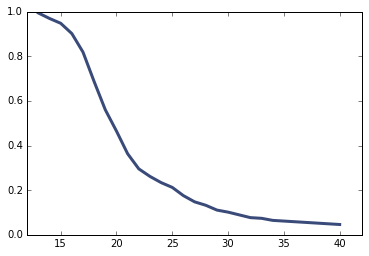

In [11]:
cohort = grouped.get_group(30)
sf = survival.MakeSurvivalFromSeq(cohort.agemarry_index.fillna(np.inf))
ts, ss = sf.Render()
print(ss)
thinkplot.Plot(ts, ss)
thinkplot.Config(xlim=[12, 42])

Then use the SurvivalFunction to compute the HazardFunction:

[ 0.00615385  0.0247678   0.02222222  0.0487013   0.09215017  0.16165414
  0.1838565   0.17032967  0.21854305  0.18644068  0.11458333  0.10588235
  0.09210526  0.17391304  0.15789474  0.10416667  0.1627907   0.08333333
  0.12121212  0.13793103  0.04        0.125       0.04761905  0.05
  0.05263158  0.11111111  0.0625      1.        ]


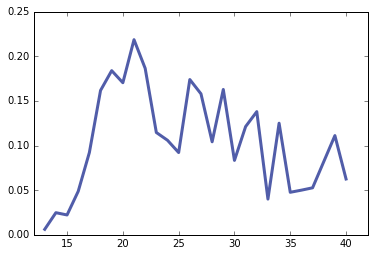

In [12]:
hf = sf.MakeHazardFunction()
ts, lams = hf.Render()
print(lams)
thinkplot.Plot(ts, lams)
thinkplot.Config(xlim=[12, 42])

Make the first figure, showing sf and hf for the 30s cohort:

In [13]:
options = dict(formats=['pdf', 'png'], clf=False)

Writing marriage1.pdf
Writing marriage1.png


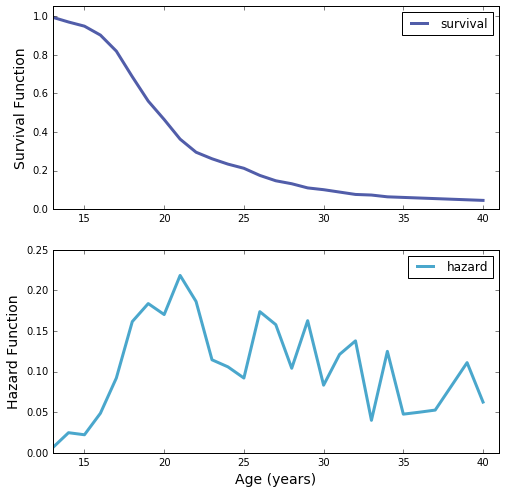

In [14]:
thinkplot.PrePlot(2, rows=2)

thinkplot.Plot(sf, label='survival')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
pyplot.ylabel('Survival Function', fontsize=14)

thinkplot.SubPlot(2)
thinkplot.Plot(hf, label='hazard')
thinkplot.Config(xlabel='age(years)', ylabel='Hazard function', xlim=[13, 41])
pyplot.ylabel('Hazard Function', fontsize=14)
pyplot.xlabel('Age (years)', fontsize=14)

thinkplot.Save(root='marriage1', **options)

Writing marriage2.pdf
Writing marriage2.png


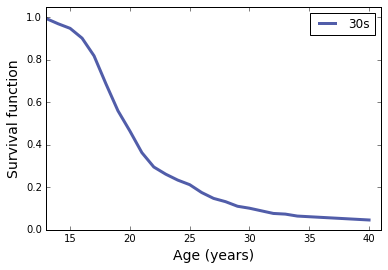

In [15]:
thinkplot.PrePlot(1)

thinkplot.Plot(sf, label='30s')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
pyplot.xlabel('Age (years)', fontsize=14)
pyplot.ylabel('Survival function', fontsize=14)

thinkplot.Save(root='marriage2', **options)

Writing marriage3.pdf
Writing marriage3.png


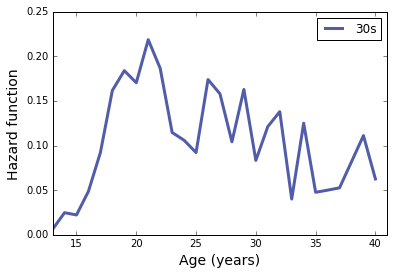

In [16]:
thinkplot.PrePlot(1)

thinkplot.Plot(hf, label='30s')
thinkplot.Config(xlim=[13, 41])
pyplot.xlabel('Age (years)', fontsize=14)
pyplot.ylabel('Hazard function', fontsize=14)

thinkplot.Save(root='marriage3', **options)

Make some pivot tables, just to see where the data are:

In [17]:
pt = df.pivot_table(index='birth_index', columns='age_index', values='age', aggfunc=len, fill_value=0)
pt

age_index,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,...,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,19,146,148,12
40,0,0,0,0,0,0,0,0,0,0,...,202,163,345,452,442,414,384,194,198,25
50,0,0,0,0,0,0,0,0,42,301,...,745,768,492,427,396,371,482,633,533,38
60,0,269,300,370,665,722,609,513,520,242,...,282,359,417,466,595,562,537,511,452,25
70,3,389,523,549,362,293,283,285,365,572,...,533,427,337,269,154,144,105,26,0,0
80,14,260,242,340,483,589,658,683,705,600,...,0,0,0,0,0,0,0,0,0,0
90,0,588,618,544,467,372,192,200,115,26,...,0,0,0,0,0,0,0,0,0,0


The following pivot table is not as helpful as it could be, since it doesn't show the number at risk.

In [18]:
df.pivot_table(index='birth_index', columns='agemarry_index', values='age', aggfunc=len, fill_value=0)

agemarry_index,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,2,8,7,15,27,43,41,...,3,1,1,1,0,2,1,0,0,0
40,1,0,0,5,31,87,163,218,425,467,...,15,12,5,6,3,9,1,1,0,0
50,0,0,1,10,50,125,384,642,1111,1057,...,50,33,27,18,12,11,7,4,4,4
60,0,1,1,5,36,113,288,420,818,805,...,62,61,31,36,21,22,14,9,7,4
70,1,1,2,6,26,49,136,198,440,507,...,35,25,8,7,6,2,2,0,0,0
80,0,0,0,4,8,26,59,72,214,262,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,0,3,7,8,19,18,...,0,0,0,0,0,0,0,0,0,0


Check where each cohort gets cut off.  For several cohorts, we only see half of the last year; in that case I drop the fractional year because it underestimates the hazard rate (and also gives too much weight to the oldest few respondents).

In [19]:
df[(df.birth_index==90) & (df.age>23.5)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


In [20]:
df[(df.birth_index==80) & (df.age>33.5)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


In [21]:
df[(df.birth_index==70) & (df.age>43.6)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


In [22]:
df[(df.birth_index==60) & (df.age>45.5)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


In [23]:
df[(df.birth_index==50) & (df.age>45.5)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


In [24]:
df[(df.birth_index==40) & (df.age>45.5)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


In [25]:
df[(df.birth_index==30) & (df.age>45.5)]

,age,age_index,ageint,agemarry,agemarry_index,birth_index,caseid,cmbirth,cmdivorcx,cmintvw,...,finalwgt,firstcm,fmarital,mar2p,missing,parity,timesmar,wgt2011_2013,wgtq1q16,year


Estimate the survival curve for each cohort:

In [26]:
%time sf_map = marriage.EstimateSurvivalByCohort(resps, iters=11)

CPU times: user 7.13 s, sys: 20 ms, total: 7.15 s
Wall time: 7.11 s


Check a sample:

In [27]:
for sf in sf_map[90]:
    print(sf.ss)
    print(sf.Prob(34))
    break

15    0.998558
16    0.997204
17    0.993643
18    0.982031
19    0.958795
20    0.919003
21    0.900311
22    0.838646
dtype: float64
0.83864632243


Select the cohort names to display:

In [28]:
year_indices = pt.index
year_indices

Int64Index([30, 40, 50, 60, 70, 80, 90], dtype='int64', name=u'birth_index')

Make the figure showing estimated survival curves:

Writing marriage4.pdf
Writing marriage4.png


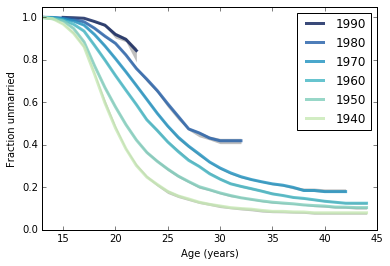

In [29]:
reload(marriage)

def PlotSurvivalFunctions(root, sf_map, sf_map_pred=None, **options):

    if sf_map_pred:
        marriage.PlotSurvivalFunctions(sf_map_pred, predict_flag=True)
    marriage.PlotSurvivalFunctions(sf_map)

    thinkplot.Config(xlim=[13, 45], ylim=[0, 1.05])

    thinkplot.Save(root=root, **options)


remap = {k:sf_map[k] for k in year_indices[1:]}
PlotSurvivalFunctions('marriage4', remap, None, **options)

Make a table of marriage rates for each cohort at each age:

In [30]:
def MakeTable(sf_map, ages):
    t = []
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [1-np.interp(age, ts, ss, right=np.nan) for age in ages]
        t.append((name, vals))
    return t

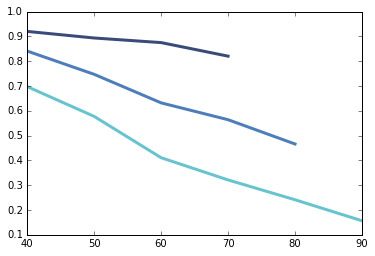

In [31]:
def PlotFractions(sf_map, **options):
    t = MakeTable(sf_map, ages)
    cohorts, cols = zip(*t)
    rows = zip(*cols)

    thinkplot.PrePlot(3)
    for age, row in reversed(zip(ages, rows)):
        thinkplot.Plot(cohorts, row, label=age, **options)
    
ages = [22, 26, 42]
PlotFractions(remap)

In [32]:
%precision 2
ages = [22, 32, 42]
for name, sf_seq in sorted(remap.items()):
    ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
    ss = ss[0]
    vals = [1-np.interp(age, ts, ss, right=np.nan) for age in ages]
    print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')

40 & 70 & 90 & 92 \\
50 & 58 & 85 & 89 \\
60 & 41 & 80 & 88 \\
70 & 32 & 75 & 82 \\
80 & 24 & 58 & nan \\
90 & 16 & nan & nan \\


Generate projections:

In [33]:
reload(marriage)
reload(survival)

%time sf_map_pred = marriage.EstimateSurvivalByCohort(resps, iters=11, predict_flag=True)

CPU times: user 6.95 s, sys: 20 ms, total: 6.97 s
Wall time: 6.94 s


And make the figure showing projections:

Writing marriage5.pdf
Writing marriage5.png


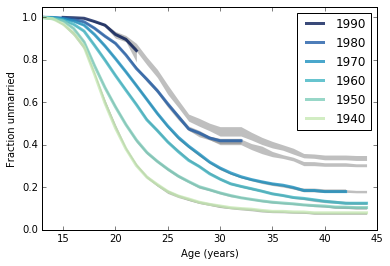

In [34]:
remap_pred = {k:sf_map_pred[k] for k in year_indices[1:]}
PlotSurvivalFunctions('marriage5', remap, remap_pred, **options)

Make the table again with the projections filled in.

In [35]:
%precision 2
ages = [22, 32, 42]
for name, sf_seq in sorted(remap_pred.items()):
    ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
    ss = ss[0]
    vals = [1-np.interp(age, ts, ss, right=np.nan) for age in ages]
    print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')

40 & 70 & 90 & 92 \\
50 & 58 & 85 & 90 \\
60 & 41 & 79 & 87 \\
70 & 32 & 75 & 82 \\
80 & 24 & 58 & 70 \\
90 & 15 & 54 & 66 \\


In [36]:
%precision 2
ages = [22, 25, 42]
for name, sf_seq in sorted(remap_pred.items()):
    ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
    ss = ss[0]
    vals = [1-np.interp(age, ts, ss, right=np.nan) for age in ages]
    print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')

40 & 70 & 82 & 92 \\
50 & 58 & 71 & 90 \\
60 & 41 & 59 & 87 \\
70 & 32 & 52 & 82 \\
80 & 24 & 41 & 70 \\
90 & 15 & 34 & 66 \\


Writing marriage6.pdf
Writing marriage6.png


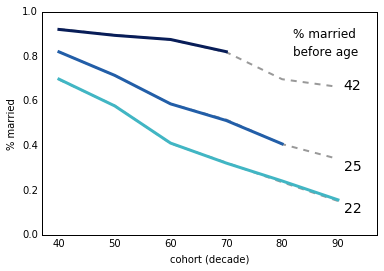

In [37]:
ages = [22, 25, 42]
PlotFractions(remap_pred, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(remap, alpha=1)
thinkplot.Text(82, 0.93, '% married', fontsize=12)
thinkplot.Text(82, 0.85, 'before age', fontsize=12)
thinkplot.Text(91, 0.7, '42', fontsize=14)
thinkplot.Text(91, 0.34, '25', fontsize=14)
thinkplot.Text(91, 0.15, '22', fontsize=14)

pyplot.tick_params(axis='x', which='both', bottom='off', top='off') 
pyplot.tick_params(axis='y', which='both', left='off', right='off') 

thinkplot.Config(xlim=[37, 97], ylim=[0, 1], xlabel='cohort (decade)', ylabel='% married', legend=False)
thinkplot.Save(root='marriage6', **options)

Run a single resampling run:

In [38]:
sf_map = marriage.EstimateSurvivalByCohort(resps, iters=1)

Print the hazard functions in table form:

In [39]:
def ComputeHazard(sf, dx=0.1, order=3):
    ts, ss = sf.Render()
    #thinkplot.Plot(ts, ss, color='gray', linewidth=10)
    low = math.ceil(min(ts))
    low = 15.0
    high = math.floor(max(ts) - order*dx)
    
    func = interp1d(ts, ss, bounds_error=False, fill_value=1.0)
    xs = np.arange(low, high+1)
    ys = func(xs)
    #thinkplot.Plot(xs, ys, color='red')
    
    hs = -derivative(func, xs, dx=dx) / ys

    return survival.HazardFunction(pd.Series(zip(xs, hs)))

hf_map = {}
for group, sf_list in sf_map.items():
    assert len(sf_list) == 1
    hf_map[group] = ComputeHazard(sf_list[0])

    
ages = np.arange(15, 45)
for age in ages:
    for group, hf in sorted(hf_map.items()):
        ts, hs = hf.Render()
        print(age, group, hf.Get(age))
    

15 30 (30.0, 0.16000000000000231)
15 40 (30.0, 0.072864321608040739)
15 50 (30.0, 0.071685062987012854)
15 60 (30.0, 0.10501542656238942)
15 70 (30.0, 0.083893614540921951)
15 80 (30.0, 0.01904761904761898)
15 90 nan
16 30 (31.0, 0.09090909090909223)
16 40 (31.0, 0.047745358090186027)
16 50 (31.0, 0.0583944245960498)
16 60 (31.0, 0.075407788356191288)
16 70 (31.0, 0.080440088461455672)
16 80 (31.0, -0.0)
16 90 nan
17 30 (32.0, 0.035714285714286233)
17 40 (32.0, 0.044263938415390773)
17 50 (32.0, 0.047759537598305979)
17 60 (32.0, 0.04972188391304249)
17 70 (32.0, 0.057373712649886693)
17 80 nan
17 90 nan
18 30 (33.0, 0.024390243902439997)
18 40 (33.0, 0.064141478981734015)
18 50 (33.0, 0.035234884826483577)
18 60 (33.0, 0.050052979116989034)
18 70 (33.0, 0.042464223862912237)
18 80 nan
18 90 nan
19 30 (34.0, 0.037500000000000547)
19 40 (34.0, 0.070898106818532688)
19 50 (34.0, 0.037444594927358479)
19 60 (34.0, 0.054534522629666814)
19 70 (34.0, 0.045791535832384822)
19 80 nan
19 90 na

In [40]:
reload(marriage)

male2002 = marriage.ReadMaleResp2002()
male2002.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,finalwgt,cmintvw,cmmarrhx,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,12178,1052,False,NaN,NaN,7085.207973,1233,NaN,NaN,15.083333,False,87,15,NaN,80
1,3233,701,True,NaN,1007,24372.450063,1237,1007,25.500000,44.666667,False,58,44,25,50
2,12170,707,True,NaN,1199,7073.132109,1234,1199,41.000000,43.916667,False,58,43,41,50
3,6629,1052,False,NaN,NaN,3105.158992,1234,NaN,NaN,15.166667,False,87,15,NaN,80
4,6531,787,True,NaN,1107,4679.548824,1235,1107,26.666667,37.333333,False,65,37,26,60


In [41]:
reload(marriage)

male2010 = marriage.ReadMaleResp2010()
male2010.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,wgtq1q16,cmintvw,cmmarrhx,finalwgt,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,36133,1043,False,NaN,NaN,7270.577055,1323,NaN,7270.577055,NaN,23.333333,False,86,23,NaN,80
1,36636,1021,False,NaN,NaN,7601.733277,1322,NaN,7601.733277,NaN,25.083333,False,85,25,NaN,80
2,41125,1118,False,NaN,NaN,4587.699601,1322,NaN,4587.699601,NaN,17.000000,False,93,17,NaN,90
3,23607,948,False,NaN,NaN,26566.111007,1287,NaN,26566.111007,NaN,28.250000,False,78,28,NaN,70
4,40814,1018,False,NaN,NaN,5709.710317,1322,NaN,5709.710317,NaN,25.333333,False,84,25,NaN,80


In [42]:
reload(marriage)

male2013 = marriage.ReadMaleResp2013()
male2013.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,wgt2011_2013,cmintvw,cmmarrhx,finalwgt,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,50001,1027,True,1346,1237,8111.081751,1348,1237,8111.081751,17.500000,26.750000,False,85,26,17,80
1,50003,1160,False,NaN,NaN,4082.414347,1354,NaN,4082.414347,NaN,16.166667,False,96,16,NaN,90
2,50006,1025,True,NaN,1335,25550.455475,1360,1335,25550.455475,25.833333,27.916667,False,85,27,25,80
3,50007,1028,False,NaN,NaN,6754.912773,1348,NaN,6754.912773,NaN,26.666667,False,85,26,NaN,80
4,50009,855,True,NaN,1152,49442.342886,1362,1152,49442.342886,24.750000,42.250000,False,71,42,24,70


In [43]:
males = [male2002, male2010, male2013]
df2 = pd.concat(males, ignore_index=True)
len(df2)

20146

In [44]:
sum(df2.missing)

0

In [45]:
marriage.DigitizeResp(df2)
grouped = df2.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()),
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

50 & 322 & 42 -- 45 & 225 & 0 \\
60 & 3608 & 32 -- 45 & 2487 & 0 \\
70 & 6004 & 22 -- 43 & 3270 & 0 \\
80 & 6999 & 15 -- 33 & 1166 & 0 \\
90 & 3213 & 15 -- 23 & 23 & 0 \\


In [46]:
%time sf_map_male = marriage.EstimateSurvivalByCohort(males, iters=21)

CPU times: user 4.38 s, sys: 8 ms, total: 4.39 s
Wall time: 4.37 s


Writing marriage7.pdf
Writing marriage7.png


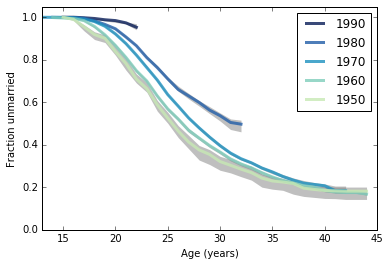

In [47]:
PlotSurvivalFunctions('marriage7', sf_map_male, None, **options)

In [48]:
%time sf_map_male_pred = marriage.EstimateSurvivalByCohort(males, iters=11, predict_flag=True)

CPU times: user 2.29 s, sys: 16 ms, total: 2.31 s
Wall time: 2.3 s


Writing marriage8.pdf
Writing marriage8.png


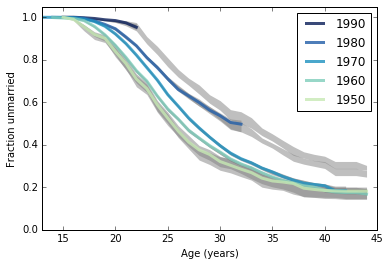

In [49]:
PlotSurvivalFunctions('marriage8', sf_map_male, sf_map_male_pred, **options)

In [52]:
reload(marriage)

from collections import defaultdict
from collections import OrderedDict

def EstimateSurvivalByCohort(resps, iters=101, predict_flag=False):
    """Makes survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    
    returns: map from group name to list of survival functions
    """
    cutoffs = {70:43, 80:33, 90:23}
    sf_map = defaultdict(list)

    # iters is the number of resampling runs to make
    for i in range(iters):
        sample = marriage.ResampleResps(resps)

        # group by decade
        grouped = sample.groupby('birth_index')

        # and estimate (hf, sf) for each group
        hf_map = OrderedDict()
        for name, group in iter(grouped):
            cutoff = FindCutoff(name, group)
            marriage.FillMissingAgemarry(group)
            hf_map[name] = marriage.EstimateSurvival(group, cutoff)

        # make predictions if desired
        if predict_flag:
            marriage.MakePredictions(hf_map)       

        # extract the sf from each pair and accumulate the results
        for name, (hf, sf) in hf_map.items():
            sf_map[name].append(sf)
             
    return sf_map

def FindCutoff(name, group):
    pass

Writing marriage9.pdf
Writing marriage9.png


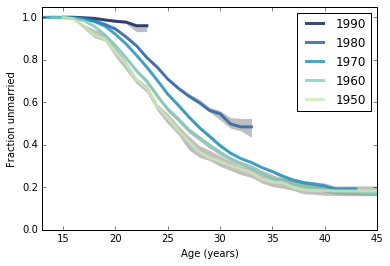

In [53]:
sf_map_male = EstimateSurvivalByCohort(males, iters=11)
PlotSurvivalFunctions('marriage9', sf_map_male, None, **options)

Writing marriage10.pdf
Writing marriage10.png


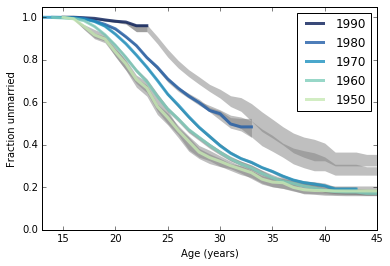

In [54]:
sf_map_male_pred = EstimateSurvivalByCohort(males, iters=11, predict_flag=True)
PlotSurvivalFunctions('marriage10', sf_map_male, sf_map_male_pred, **options)